# ePSproc wavefunction plotting tests & demo: CH3I with animation
11/08/20


This notebook demos (continuum photoelectron) wavefunction plotting from ePS gridded file outputs, for a large dataset including animation. (See the [basic notebook for starter demo material](https://epsproc.readthedocs.io/en/dev/demos/ePSproc_wfPlot_tests_150720-030820_tidy.html).) The plotting is handled with [pyVista](https://docs.pyvista.org/), with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) for interactive plotting. Both tools are built on the [ITK/VTK toolchain](https://vtk.org/).

Aims:

- Test & demo `wfPlotter` class for large datasets.
- Demo animation routine.

See also:

- Basic dev notebook, https://epsproc.readthedocs.io/en/dev/demos/ePSproc_wfPlot_tests_150720-030820_tidy.html
- Orbital plotting, https://epsproc.readthedocs.io/en/dev/methods/ePSproc_orbPlot_tests_130520.html
- ePSdata interface demo, https://epsproc.readthedocs.io/en/dev/demos/ePSdata_download_demo_300720.html


Versions

- 11/08/20  updating with rewritten plotWf method.
- 03/08/20  v1 and testing

## Setup

In [1]:
# Standard libs
import sys
import os
from pathlib import Path
import numpy as np
import xarray as xr

from datetime import datetime as dt
timeString = dt.now()

# For reporting
import scooby
# scooby.Report(additional=['holoviews', 'hvplot', 'xarray', 'matplotlib', 'bokeh'])
# TODO: set up function for this, see https://github.com/banesullivan/scooby

In [2]:
# Installed package version
# import epsproc as ep  

# ePSproc test codebase (local)
if sys.platform == "win32":
    modPath = r'D:\code\github\ePSproc'  # Win test machine
else:
    modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
    
sys.path.append(modPath)
import epsproc as ep

* plotly not found, plotly plots not available. 
* pyevtk not found, VTK export not available. 


## wfPlotter class

Data IO and plotting functions are set in the `wfPlotter` class.

In [3]:
from epsproc.vol.wfPlot import wfPlotter

# Load data from modPath\data
# dataPath = os.path.join(modPath, 'data', 'wavefn')  # Case for single test dataset in ePSproc repo

# Load data from an ePSdata download, 
# See https://epsproc.readthedocs.io/en/dev/demos/ePSdata_download_demo_300720.html
dataPath = r'/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn'

wfClass = wfPlotter(fileBase = dataPath)


*** Scanning dir
/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn
Found 48 _Orb.dat file(s)

/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3IS
Found molecule: CH3I
Found 2 symmetries, ['SA1CA1', 'SECE']
Found 24 energies, [1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0, 23.5, 26.0, 28.5, 31.0, 33.5, 36.0, 38.5, 41.0, 43.5, 46.0, 48.5, 51.0, 53.5, 56.0, 58.5]

*** Read existing plot options from file /home/femtolab/github/ePSproc/epsproc/vol/plotOptions.json OK.


File names are stored in `.fList`
This is sorted in "natural" order with [the natsort library](https://pypi.org/project/natsort/), or python's native `sorted()` function if `natsort` is not available.

In [4]:
# First 10 files in the sorted list
wfClass.fList[0:10]

['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_1.0eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_3.5eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_6.0eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_8.5eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_11.0eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_13.5eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_16.0eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_18.5eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_21.0eV_Orb.dat',
 '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_23.5eV_Orb.dat']

Job details are also extracted from the filenames, and stored in `.fDictE` (energy sorted) and `.fDictSym` (symmetry sorted). These are both accessed by simple integer keys.

In [5]:
wfClass.fDictE[0]

{'E': 1.0,
 'fList': ['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_1.0eV_Orb.dat',
  '/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISECE_1.0eV_Orb.dat'],
 'mol': 'CH3I',
 'syms': ['SA1CA1', 'SECE']}

## Select & read files

Since there might be quite a bit of data, the files are not read initially. This allows for subselection from the full file list. This can be done via the `.selectOrbFiles()` method, which will set values for IO, or by passing the selection parameters to the `.readOrbFiles()` method.

### Data dictionaries and subselection
Subselection can be made by index value (int), energy value (float) or symmetry group...

In [6]:
# The .selectOrbFiles() method is used for selection, 
# This is used by .readOrbFiles() below, but can also be called independently (without reading files)

# With ints (index) values
wfClass.selectOrbFiles(EList = [0,5,7])

Selected 3 energies, [1.0, 13.5, 18.5]
Selected symmetries, ['SA1CA1', 'SECE']


In [7]:
# With floats, which must correspond to exact values for the data items
wfClass.selectOrbFiles(EList = [8.5,16.0, 16.1])

# Note that unmatched values are ignored here.
# TODO: add a range option and nearest value matching

Selected 2 energies, [8.5, 16.0]
Selected symmetries, ['SA1CA1', 'SECE']


In [8]:
# With symmetries
wfClass.selectOrbFiles(SymList = 'SA1CA1')

Selected 24 energies, [1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0, 23.5, 26.0, 28.5, 31.0, 33.5, 36.0, 38.5, 41.0, 43.5, 46.0, 48.5, 51.0, 53.5, 56.0, 58.5]
Selected symmetries, ['SA1CA1']


In [9]:
# With a combination
wfClass.selectOrbFiles(EList = [0,1,6], SymList = 'SA1CA1')

Selected 3 energies, [1.0, 3.5, 16.0]
Selected symmetries, ['SA1CA1']


In [10]:
# There's also head & tail methods to check the selected items
wfClass.head()

Item key: 0


{'E': 1.0,
 'fList': ['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_1.0eV_Orb.dat'],
 'mol': 'CH3I',
 'syms': ['SA1CA1']}

In [11]:
wfClass.tail()

Item key: 6


{'E': 16.0,
 'fList': ['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_16.0eV_Orb.dat'],
 'mol': 'CH3I',
 'syms': ['SA1CA1']}

### File IO

This is handled by `.readOrbFiles()`. If a subselection has already been set, it will be used by default, otherwise *all* files will be read. Selections can also be made as above, plus the additional option of passing a file list directly.

In [12]:
# Default case - here the previous selection is used.
wfClass.readOrbFiles()


*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_1.0eV_Orb.dat']

*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_3.5eV_Orb.dat']

*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_16.0eV_Orb.dat']

Read 3 wavefunction data files OK.
*** Grids set OK
*** Data set OK


In [13]:
# Set which files should be read, can pass a list of paths here, or index into .fList with ints.
# Note that, in this case, the original fList is reused, and items are resorted, so may not match self.fDictE or self.fDictSym
subSet = [0,5,10,15]  
wfClass.readOrbFiles(fList=subSet)

/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3IS
Selected 4 energies, [1.0, 13.5, 26.0, 38.5]
Selected symmetries, ['SA1CA1']

*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_1.0eV_Orb.dat']

*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_13.5eV_Orb.dat']

*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_26.0eV_Orb.dat']

*** Scanning file(s)
['/home/femtolab/Downloads/3660708/CH3I_1-60eV/orb20_A1_waveFn/CH3ISA1CA1_38.5eV_Orb.dat']

Read 4 wavefunction data files OK.
*** Grids set OK
*** Data set OK


In [14]:
# The data items previously set now have all the data appended.
# This is set as a PyVista object in the 'vol' dictionary item
wfClass.head()['vol']

# NOTE - PyVista items are indexed sequentially, so may not match input dict keys. This may change in future.

Item key: 0


StructuredGrid (0x7f85332c36e0)
  N Cells:	129600
  N Points:	137751
  X Bounds:	-1.000e+01, 1.000e+01
  Y Bounds:	-1.000e+01, 1.000e+01
  Z Bounds:	-1.000e+01, 1.000e+01
  Dimensions:	51, 37, 73
  N Arrays:	3

In [15]:
wfClass.tail()['vol']

Item key: 3


StructuredGrid (0x7f85332c3750)
  N Cells:	129600
  N Points:	137751
  X Bounds:	-1.000e+01, 1.000e+01
  Y Bounds:	-1.000e+01, 1.000e+01
  Z Bounds:	-1.000e+01, 1.000e+01
  Dimensions:	51, 37, 73
  N Arrays:	3

## Plot

The default plot is interactive (with VTK), and will show all the loaded datasets (with given type). Rotation, visibilities and opacities of each plotted dataset can be changed via the menu in the plot window. This is good for initial data exploration. Note, however, that this needs a live notebook process, and won't render in static HTML output.

In [16]:
wfClass.plotWf(pType='Re', opacity=0.3)

Set plotter to PlotterITK


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Subplots

For non-interactive data exploration, subplots can be used.

Set plotter to Plotter


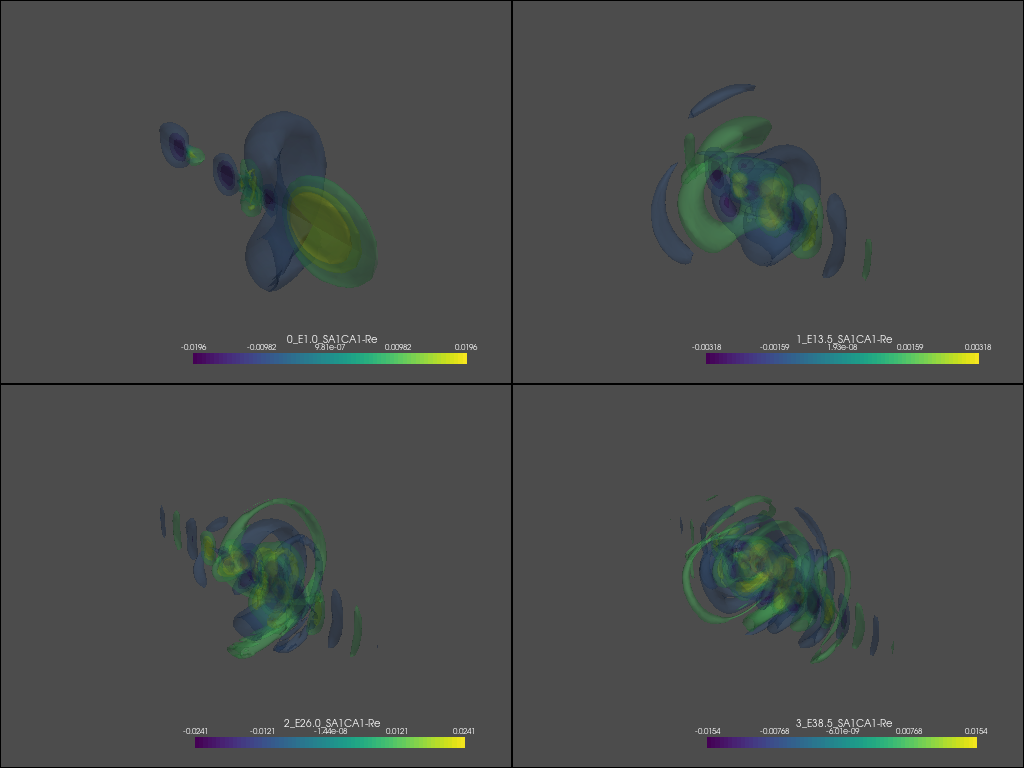

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [17]:
wfClass.plotOptions['global']['subplot'] = True
wfClass.plotWf(pType='Abs')

## Animation

Multiple frame output and gif generation is (just about) supported.

TODO: 

- fix global colormap
- more annotations
- frame rate

In [18]:
wfClass.plotOptions['global']['subplot'] = False
wfClass.plotOptions['global']['animate'] = True

Frame images output to:  /tmp/wfAnimation_CH3I_14-08-20_18-52-37
GIF animation file:  /tmp/wfAnimation_CH3I_14-08-20_18-52-37/wfAnimation_CH3I_14-08-20_18-52-37.gif
Set plotter to Plotter


ERROR:root:The interactor must be set prior to enabling/disabling widget


Animation output complete.



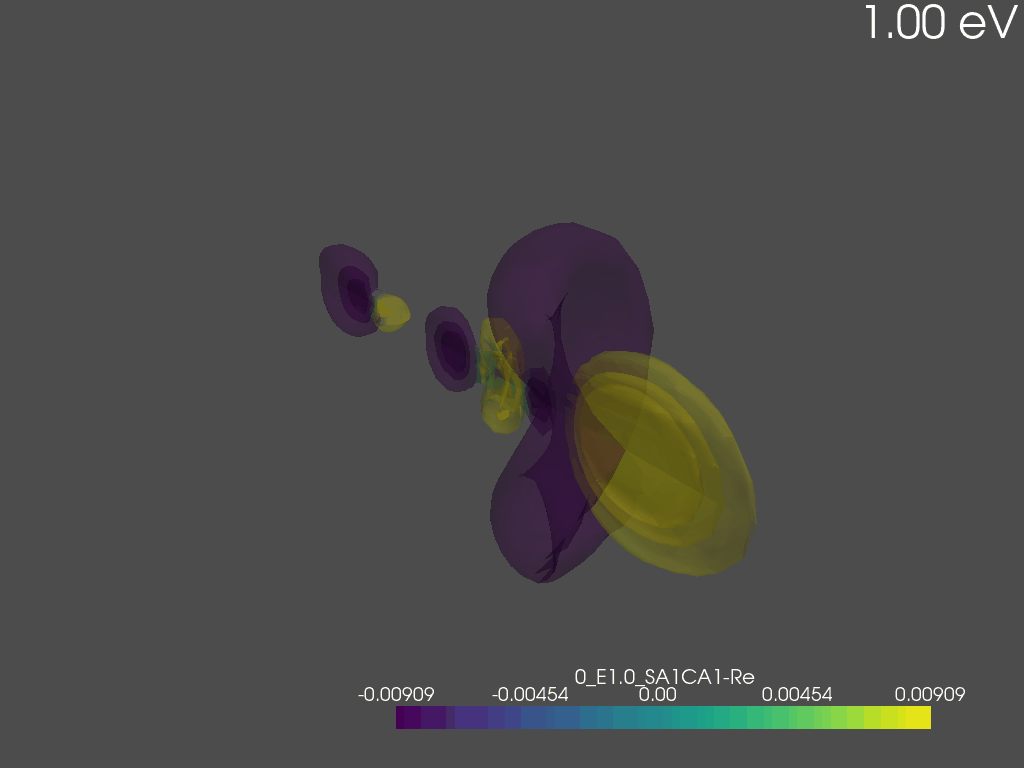

In [19]:
wfClass.plotWf(pType='Abs')

In [20]:
# To get the file path
wfClass.gifFile

PosixPath('/tmp/wfAnimation_CH3I_14-08-20_18-52-37/wfAnimation_CH3I_14-08-20_18-52-37.gif')


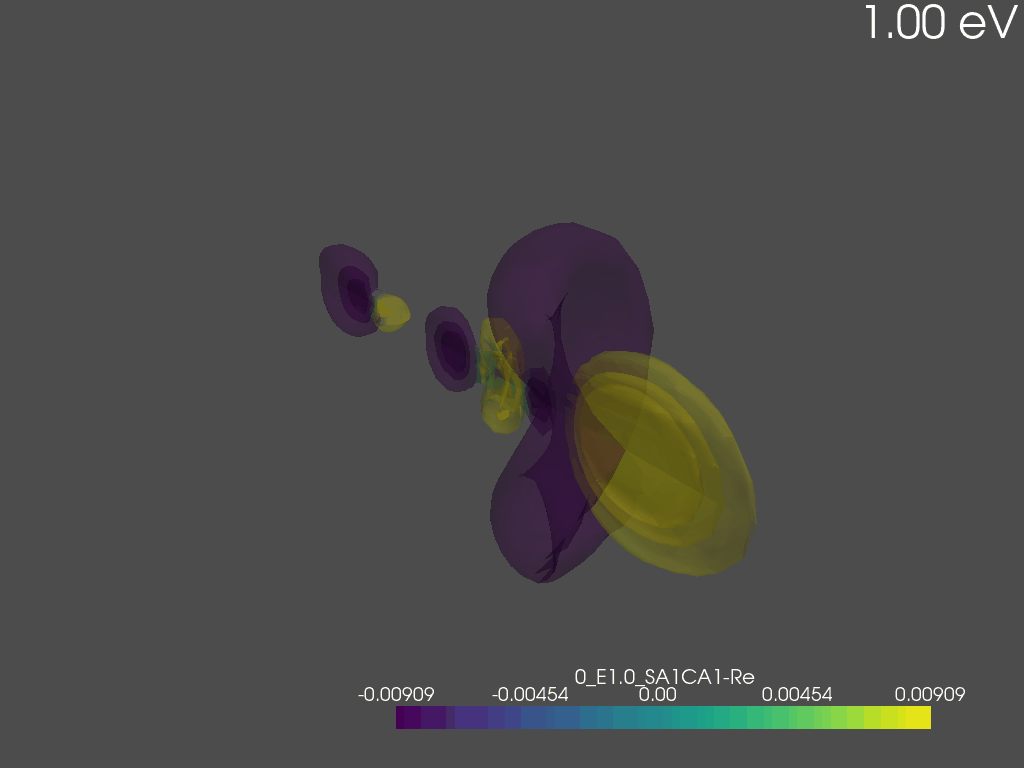

In [21]:
# To show the gif
wfClass.showGif()

## Plot options

The default plot options are set in a dictionary. Some options can also be passed directly to the plotter. Currently the defaults are initially read from file, and custom options files can also be used.

TODO:

- more options to set, including plotter-specific cases.
- general `set` functionality, rather than manual assignment.

In [22]:
# Currently set plotOptions
wfClass.plotOptions

{'global': {'note': 'Global plot settings, used as defaults. To change for session, overwrite in local dict. To change permanently, overwrite in file plotOptions.json. To reset, use `epsproc/vol/set_plot_options_json.ipynb` or .py.',
  'pType': 'Abs',
  'interactive': False,
  'inline': True,
  'animate': True,
  'isoLevels': 6,
  'isoValsAbs': None,
  'isoValsPC': None,
  'isoValsGlobal': True,
  'opacity': 0.3,
  'subplot': False},
 'BGplotter': {'addAxis': True, 'kwargs': {}}}

In [23]:
# Reset local values from file
wfClass.setPlotOptions()

Overwrite local plot options with settings from file (y/n)? y

*** Read existing plot options from file /home/femtolab/github/ePSproc/epsproc/vol/plotOptions.json OK.


In [24]:
# Setting local options to follow!
wfClass.setPlotOptions(subplot=True)

Arb option setting not yet supported, but can be manually assigned to self.plotOptions dictionary.


In [25]:
# Manual assignment to nested dictionary
wfClass.plotOptions['global']['opacity'] = 0.5

wfClass.plotOptions['global']['opacity']

0.5

## Versions

In [26]:
import scooby
scooby.Report(additional=['epsproc', 'pyvista', 'xarray'])

--------------------------------------------------------------------------------
  Date: Fri Aug 14 19:02:47 2020 EDT

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

           epsproc : 1.2.5-dev
           pyvista : 0.23.1
            xarray : 0.13.0
             numpy : 1.18.1
             scipy : 1.3.1
           IPython : 7.13.0
        matplotlib : 3.2.0
            scooby : 0.5.5

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------